In [37]:
import pandas as pd
import numpy as np

from itertools import groupby
from scipy import spatial
from itertools import combinations
from mutspec_utils.draw import plot_mutspec192, plot_mutspec12

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


### Read file with counted codons

In [38]:
counted_codons = pd.read_csv("../data/counted_codons_cytb.csv")
counted_codons = counted_codons.drop("Gene", axis=1)
counted_codons  = counted_codons.drop("Unnamed: 0", axis=1)
counted_codons.head()


,Species,ExpectedObserved,A[A>G]A,A[A>G]C,A[A>G]G,A[A>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,...,A[G>C]A,A[G>T]A,A[G>T]G,A[G>T]T,A[T>A]A,A[T>A]G,A[T>A]T,A[T>G]A,A[T>G]G,A[T>G]T
0,Abbottina_obtusirostris,Expected,8.0,4.0,4.0,4.0,12.0,10.0,10.0,17.0,...,0,0,0,0,0,0,0,0,0,0
1,Abbottina_obtusirostris,Observed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Abbottina_rivularis,Expected,6.0,3.0,3.0,3.0,16.0,11.0,9.0,21.0,...,0,0,0,0,0,0,0,0,0,0
3,Abbottina_rivularis,Observed,2.0,1.0,0.0,1.0,6.0,4.0,3.0,3.0,...,0,0,0,0,0,0,0,0,0,0
4,Abramis_brama,Expected,9.0,3.0,4.0,5.0,8.0,9.0,9.0,18.0,...,0,0,0,0,0,0,0,0,0,0


###  Change format of table for better counting

In [39]:
_counted_codons = counted_codons.melt(["Species", "ExpectedObserved"], counted_codons.columns[2:], var_name="Mut")
_counted_codons.head()

,Species,ExpectedObserved,Mut,value
0,Abbottina_obtusirostris,Expected,A[A>G]A,8.0
1,Abbottina_obtusirostris,Observed,A[A>G]A,0.0
2,Abbottina_rivularis,Expected,A[A>G]A,6.0
3,Abbottina_rivularis,Observed,A[A>G]A,2.0
4,Abramis_brama,Expected,A[A>G]A,9.0


In [40]:
mutations = _counted_codons.pivot(index=["Species", "Mut"], columns="ExpectedObserved", values="value").reset_index()
mutations.head()

ExpectedObserved,Species,Mut,Expected,Observed
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0


### Calculate RawMuspec for each species

In [41]:
mutations["RawMutSpec"] = (mutations["Observed"] / mutations["Expected"]).fillna(0)
mutations["RawMutSpec"] = mutations["RawMutSpec"].replace(np.inf, 0)
mutations.head()

ExpectedObserved,Species,Mut,Expected,Observed,RawMutSpec
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0


In [42]:
rawsum_df = mutations.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
rawsum_df.head()

,Species,RawMutSpecSum
0,Abbottina_obtusirostris,1.088889
1,Abbottina_rivularis,67.375092
2,Abramis_brama,8.375200
3,Acanthogobius_hasta,3.213889
4,Acanthopagrus_latus,0.154762


### Final Mutational spectrum

In [43]:
mutspecs = pd.merge(mutations, rawsum_df, on="Species")
mutspecs["MutSpec"] = mutspecs["RawMutSpec"] / mutspecs["RawMutSpecSum"]
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0


In [44]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

### Here we translate our mutspec with reverse on HEAVY CHAIN

In [45]:
mutspecs['Mut'] = mutspecs.Mut.apply(getrevers)
mutspecs["MutBase"] = mutspecs.Mut.str.slice(2, 5)
mutspecs["Context"] = mutspecs.Mut.str.get(0) + mutspecs.Mut.str.get(2) + mutspecs.Mut.str.get(-1)
mutspecs.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT


### Function to draw MutSpec

### Plot Mutational Spectrum for all Vertebrates

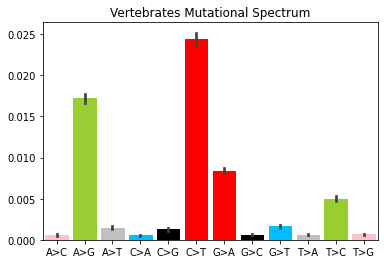

<AxesSubplot:title={'center':'Vertebrates Mutational Spectrum'}>

In [48]:
mut12_cont = mutspecs.drop('Mut', axis=1)
mut12_cont = mut12_cont.rename(columns={'MutBase':'Mut'})
plot_mutspec12(mut12_cont, title='Vertebrates Mutational Spectrum', savepath='../pictures/MutSpec/Mut12Vert.pdf')

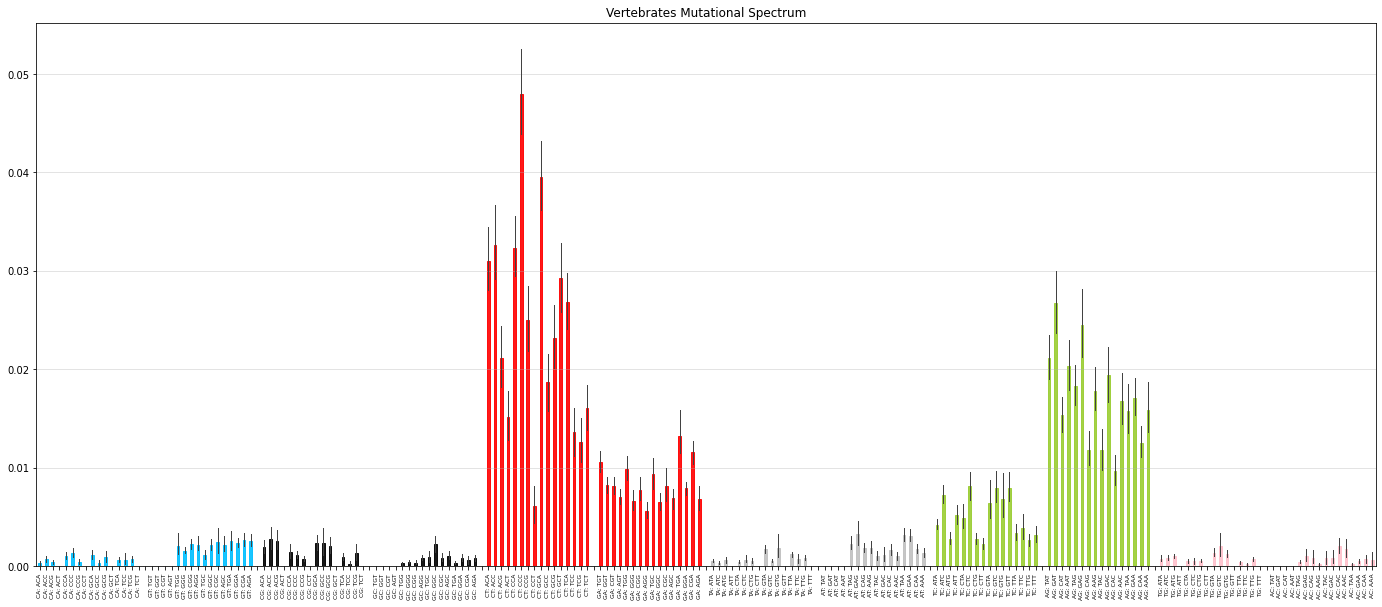

In [12]:
plot_mutspec192(mutspecs, title='Vertebrates Mutational Spectrum', filepath='../pictures/MutSpec/MutSpec192Vert.pdf')

### Add taxonomy and get mutspec for 5 orders

In [13]:
taxa = pd.read_csv('../data/taxa_gb.csv', sep='\t')
taxa.head()

,Class,Species
0,Aves,Corvus_frugilegus
1,Mammalia,Rhinopithecus_bieti
2,Mammalia,Cheracebus_lugens
3,Mammalia,Chiropotes_israelita
4,Mammalia,Callimico_goeldii


### How many classes we have

How many classes obtained from mutspec

In [14]:
taxa['Class'].value_counts()

Actinopterygii    2855
Mammalia          1464
Aves              1007
Amphibia           325
Lepidosauria       294
Name: Class, dtype: int64

How many species by classes left after merging with mutspec

In [15]:
final_mutspec = pd.merge(mutspecs, taxa, on='Species')
final_mutspec = final_mutspec.drop_duplicates()

In [16]:
final_mutspec['Class'].value_counts()//192

Actinopterygii    457
Mammalia          384
Aves               72
Lepidosauria       36
Amphibia           25
Name: Class, dtype: int64

How many species we have

In [17]:
len(final_mutspec.Species.unique())

974

In [18]:
# save mutspec of cytb for all vertebrates
final_mutspec.to_csv('../data/MutSpecVertebratescytb.csv', index=False)

### Draw Mutational Spectra for different classes

In [19]:
taxes_to_draw = ['Mammalia', 'Aves', 'Actinopterygii', 'Lepidosauria', 'Amphibia']

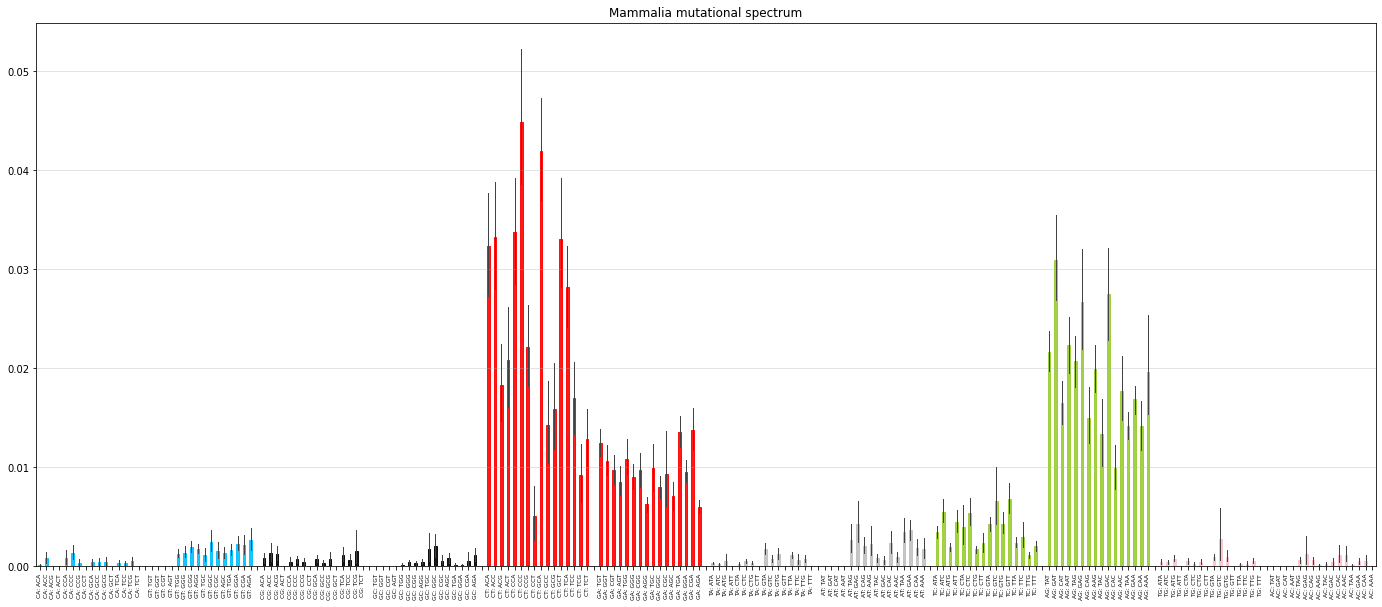

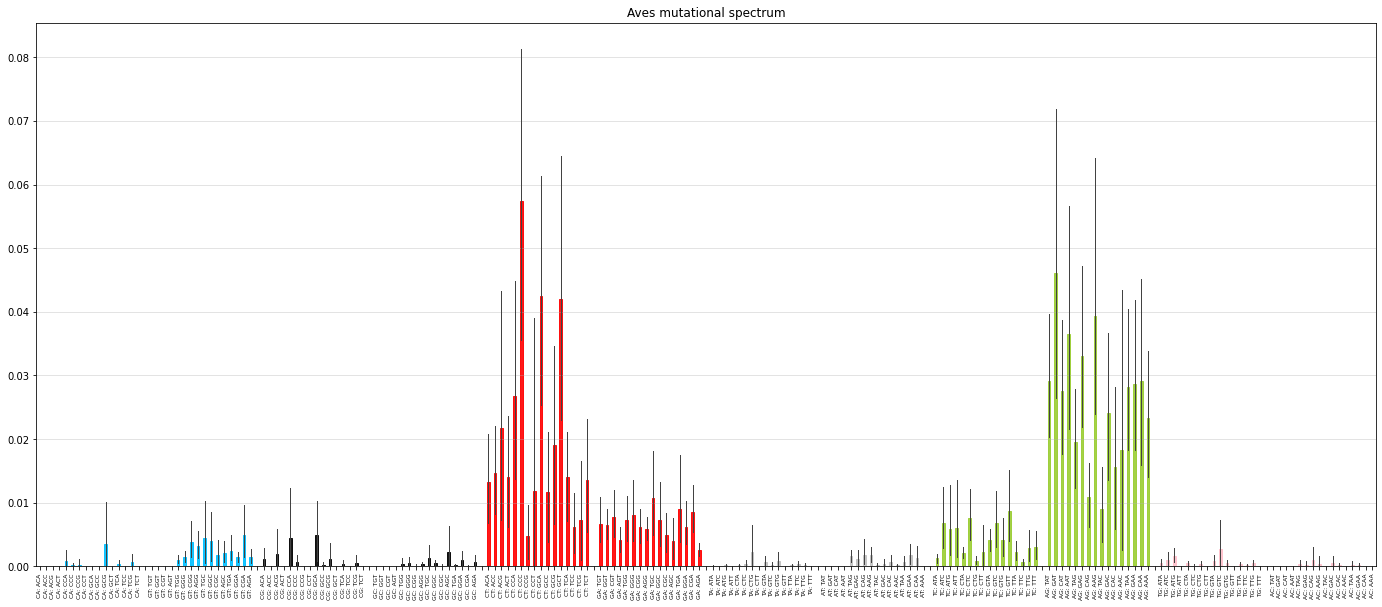

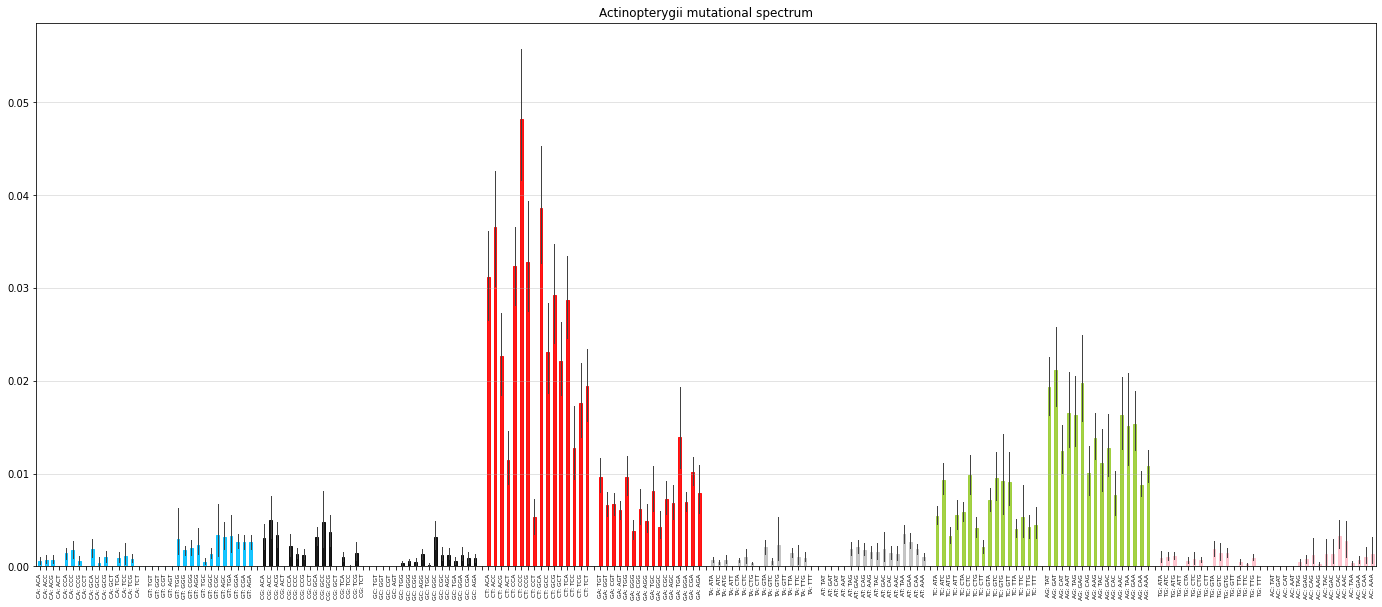

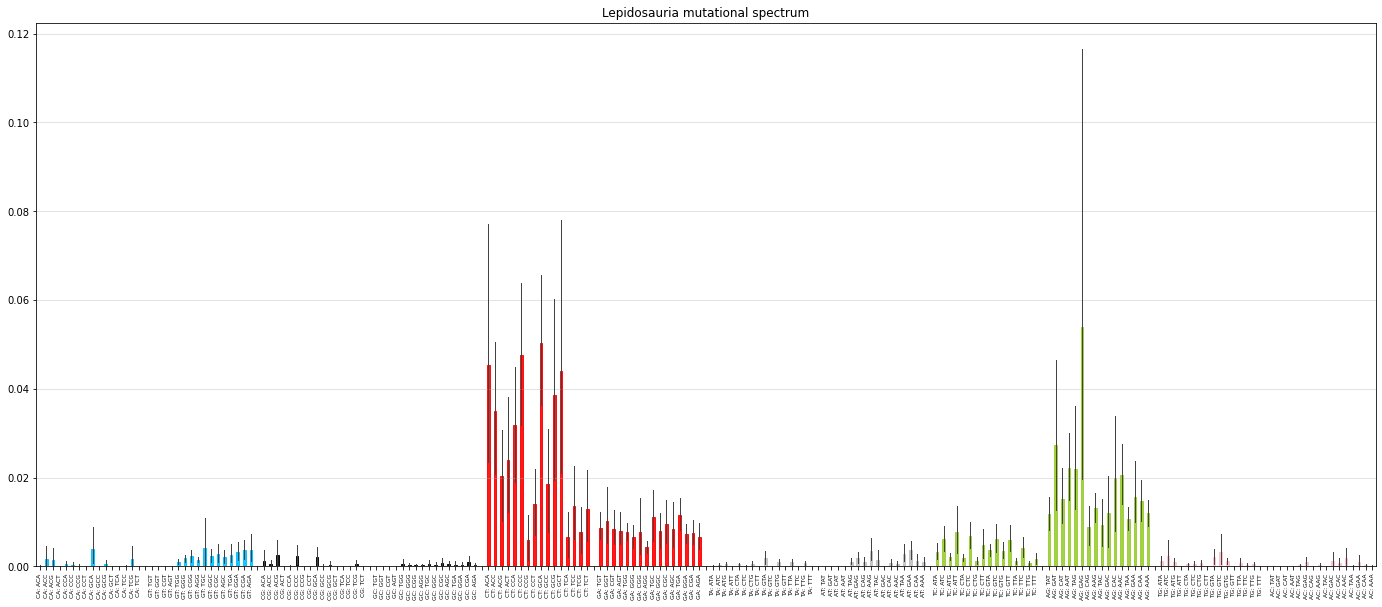

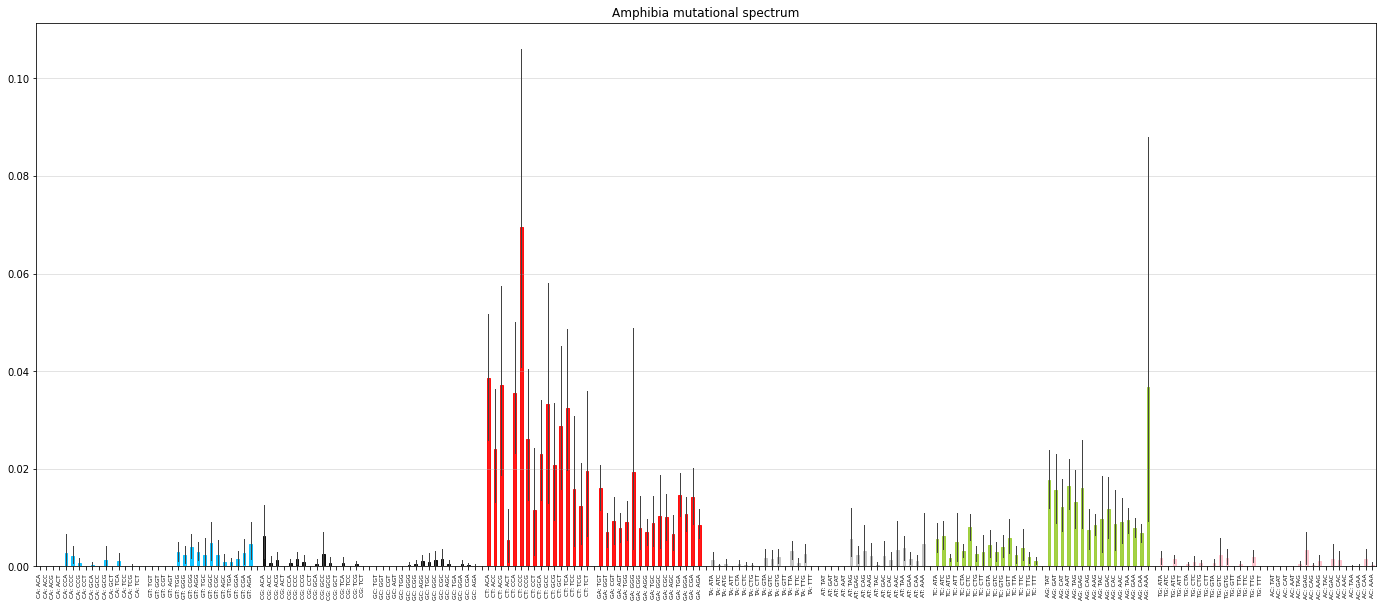

In [20]:
for tax in taxes_to_draw:
    plot_mutspec192(final_mutspec[final_mutspec['Class'] == tax], title=f'{tax} mutational spectrum',
    filepath=f'../pictures/Mutspec/{tax}Mut192Comp.pdf')

## Analys of similarity

In [21]:
needed_classes = ['Mammalia', 'Aves', 'Amphibia', 'Lepidosauria', 'Actinopterygii', 'exdloop']

### Calculate mean mutspec for each class 

In [22]:
final_mutspec.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [23]:
ms_cls = final_mutspec.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
ms_cls.tail()

,Class,Mut,MutSpec
955,Mammalia,T[T>C]T,0.001858
956,Mammalia,T[T>G]A,0.000303
957,Mammalia,T[T>G]C,0.000388
958,Mammalia,T[T>G]G,0.000603
959,Mammalia,T[T>G]T,0.000000


## Download cancer mutspec 

In [24]:
cancer = pd.read_csv('../data/external/cancer_mutspec.csv')
cancer = cancer.loc[:,['Mut','MutSpec_ExDloop']]

In [25]:
cancer.head()

,Mut,MutSpec_ExDloop
0,A[A>C]A,0.000000
1,A[A>C]C,0.000783
2,A[A>C]G,0.000000
3,A[A>C]T,0.000084
4,A[A>G]A,0.008273


In [26]:
exdloop = cancer.iloc[:,[0,1]]
exdloop['Class'] = 'cancer'
exdloop = exdloop.rename(columns={'MutSpec_ExDloop': 'MutSpec'})


In [27]:
to_cosinus = pd.concat([exdloop, ms_cls])
to_cosinus.head()

,Mut,MutSpec,Class
0,A[A>C]A,0.000000,cancer
1,A[A>C]C,0.000783,cancer
2,A[A>C]G,0.000000,cancer
3,A[A>C]T,0.000084,cancer
4,A[A>G]A,0.008273,cancer


### Analysis of C>T on heavy chain as a hallmark of oxidative damage

In [28]:
final_mutspec.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [29]:
CT_only = final_mutspec[final_mutspec['MutBase'] == 'C>T']
C_T_arr = ["A[C>T]A", "A[C>T]C", "A[C>T]G", "A[C>T]T", "C[C>T]A", "C[C>T]C", "C[C>T]G", "C[C>T]T", 
    "G[C>T]A", "G[C>T]C", "G[C>T]G", "G[C>T]T", "T[C>T]A", "T[C>T]C", "T[C>T]G", "T[C>T]T"]

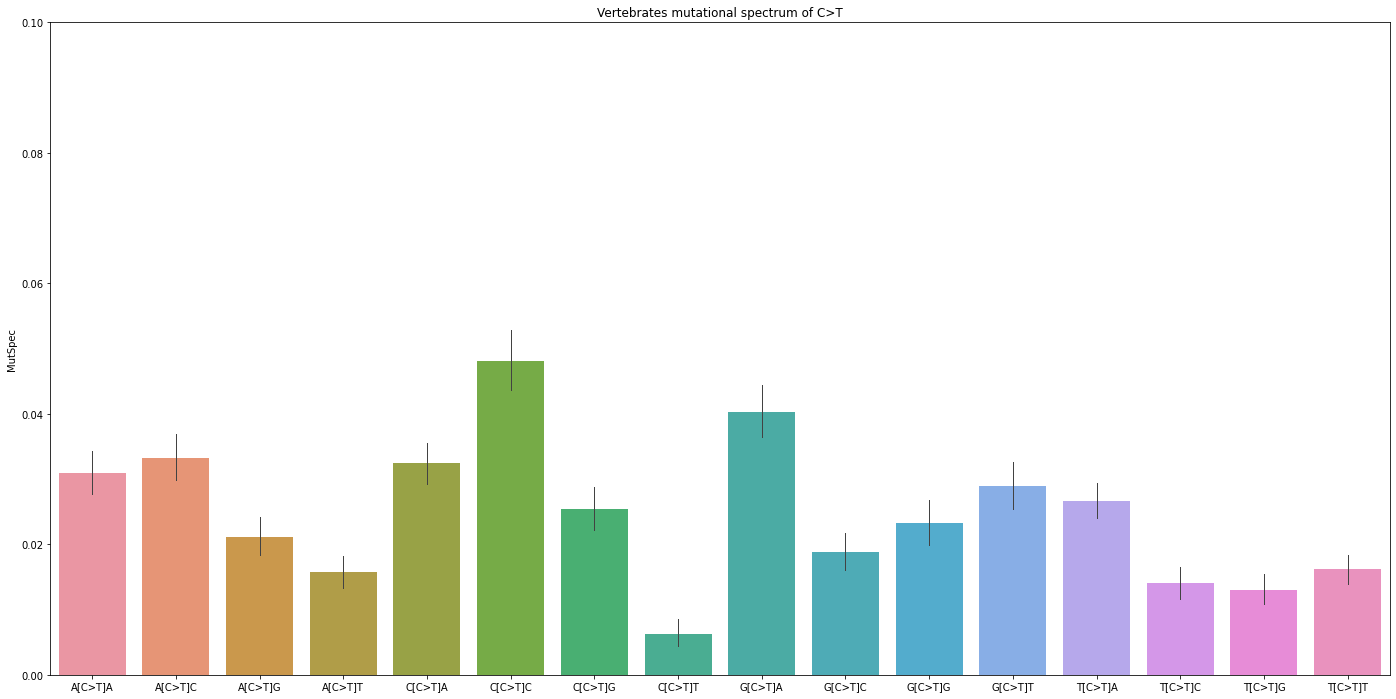

In [30]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=CT_only,
            order=C_T_arr, errwidth=1, ax=fig.gca())
ax.set_xlabel('')
ax.set_title('Vertebrates mutational spectrum of C>T')
ax.set_ylim(0,0.10)
plt.savefig('../pictures/MutSpec/CTMutVert.pdf',dpi=300)


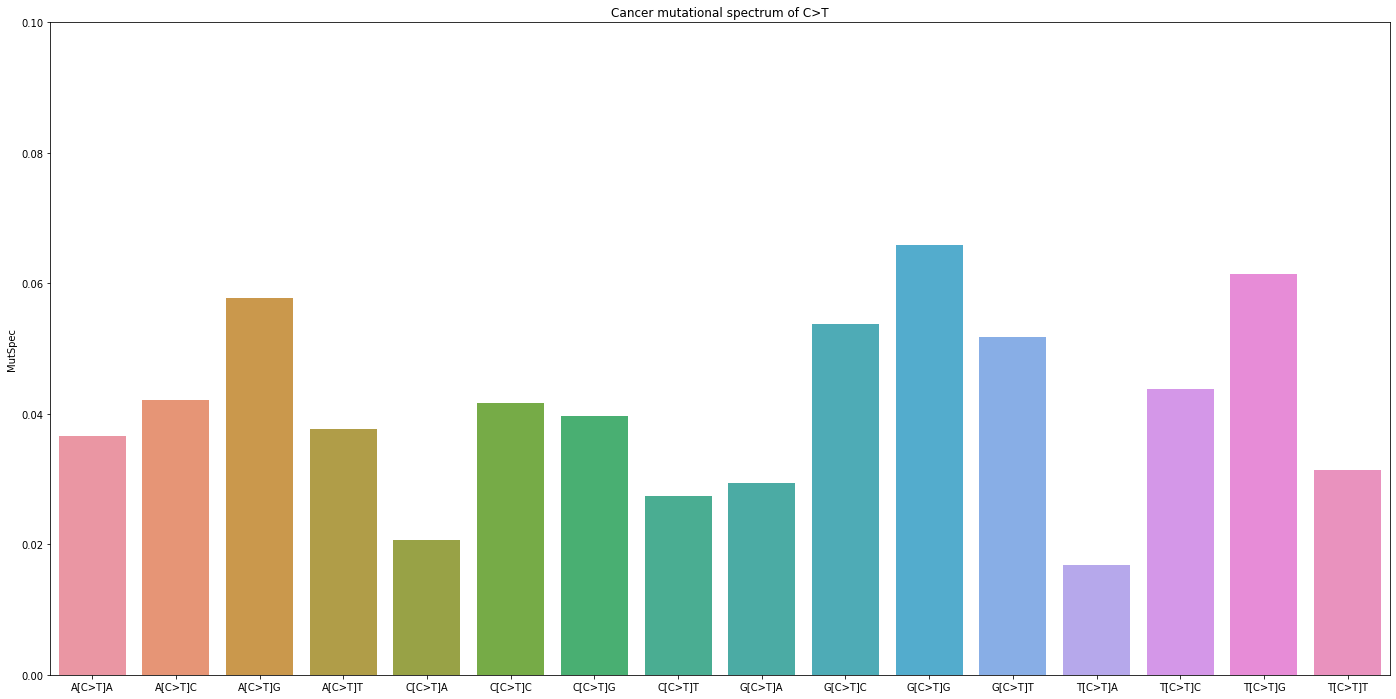

In [31]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=exdloop[exdloop['Mut'].isin(C_T_arr)],
            order=C_T_arr, ax=fig.gca())
ax.set_xlabel('')
ax.set_title('Cancer mutational spectrum of C>T')
ax.set_ylim(0,0.10)
plt.savefig('../pictures/MutSpec/CTMutCancer.pdf',dpi=300)


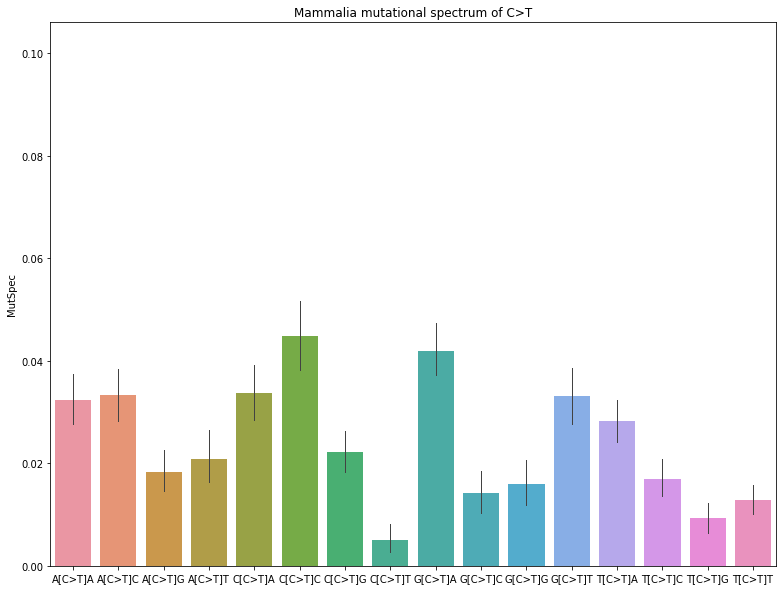

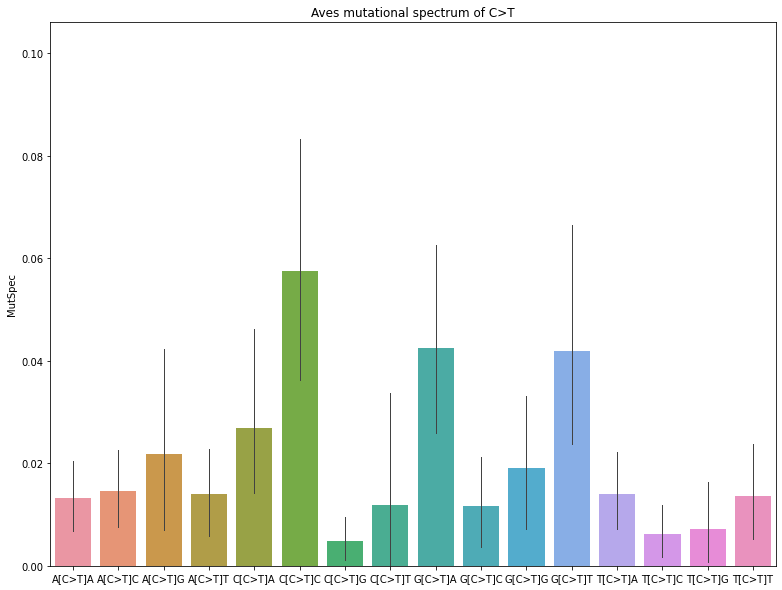

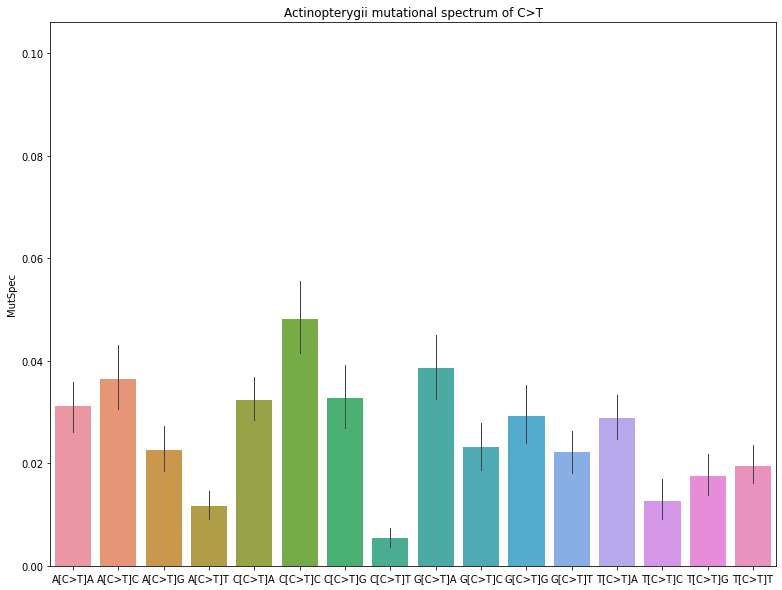

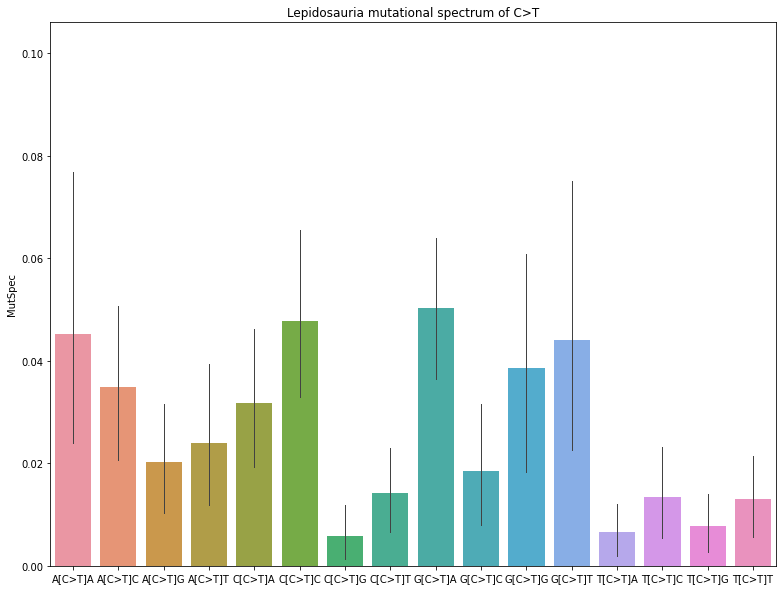

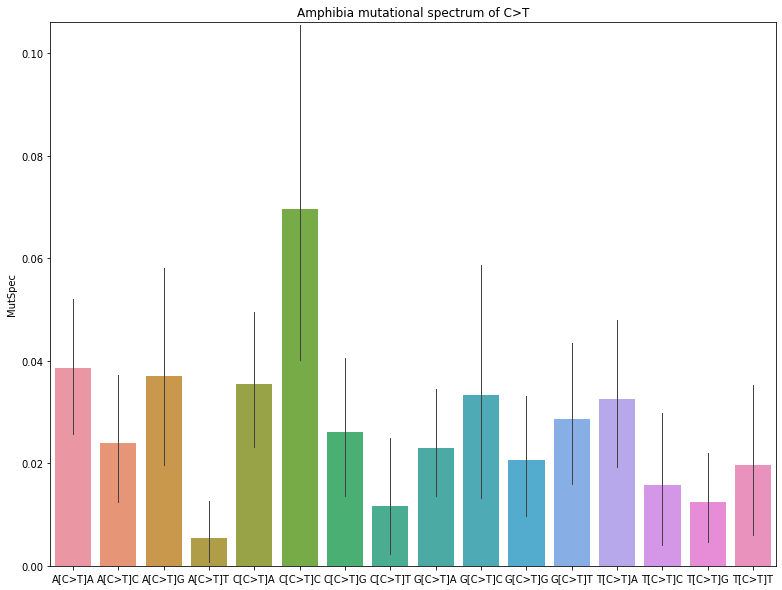

In [ ]:
for tx in taxes_to_draw:
    fig = plt.figure(figsize=(13, 10))
    ax = fig.add_subplot(111)   
    sns.barplot(x="Mut", y="MutSpec", data=CT_only[CT_only.Class == tx],
                order=C_T_arr, errwidth=1, ax=fig.gca())
    ax.set_xlabel('')
    ax.set_title(f'{tx} mutational spectrum of C>T')
    ax.set_ylim(0, 0.106)


### Analysis of A>G on heavy chain as a hallmark of 6MA

In [33]:
AG_only = final_mutspec[final_mutspec['MutBase'] == 'A>G']
A_G_arr = ["A[A>G]A", "A[A>G]C", "A[A>G]G", "A[A>G]T", "C[A>G]A", "C[A>G]C", "C[A>G]G", "C[A>G]T", 
    "G[A>G]A", "G[A>G]C", "G[A>G]G", "G[A>G]T", "T[A>G]A", "T[A>G]C", "T[A>G]G", "T[A>G]T"]
    

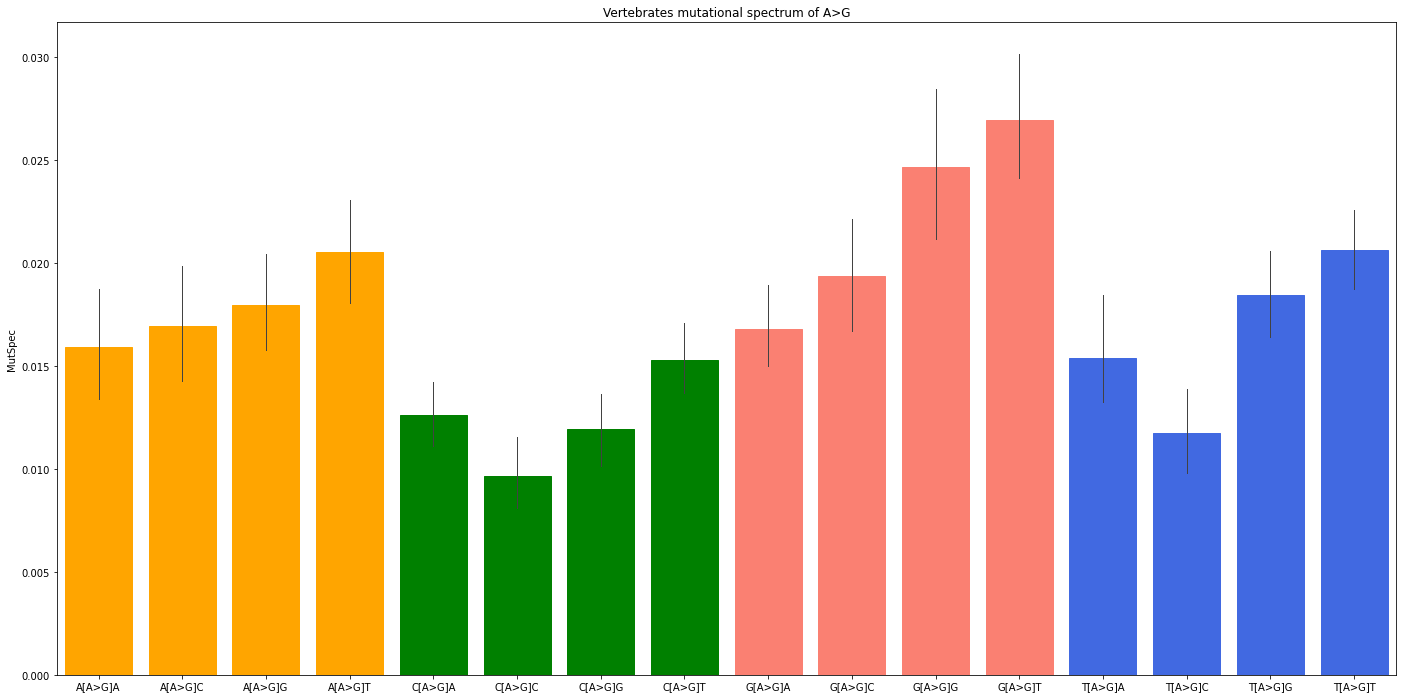

In [34]:
fig = plt.figure(figsize=(24, 12))
ax = fig.add_subplot(111)
sns.barplot(x="Mut", y="MutSpec", data=AG_only,
            order=A_G_arr, errwidth=1, ax=fig.gca())
colorsAG = ['orange','orange','orange','orange','green','green','green','green',
            'salmon','salmon','salmon','salmon','royalblue','royalblue','royalblue','royalblue']
for bar, clr in zip(ax.patches, colorsAG):
        bar.set_color(clr)
ax.set_xlabel('')
ax.set_title('Vertebrates mutational spectrum of A>G')
plt.savefig('../pictures/MutSpec/AGMutVert.pdf',dpi=300)
plt.show()

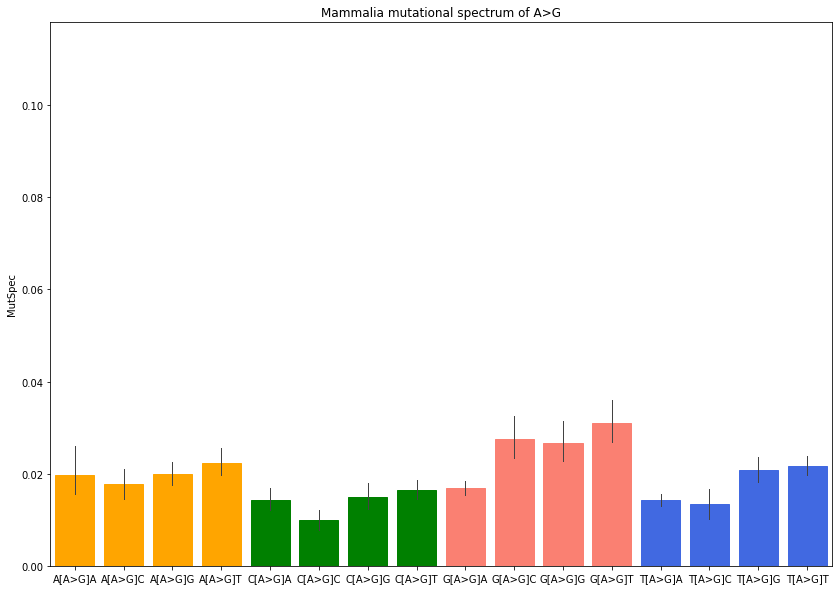

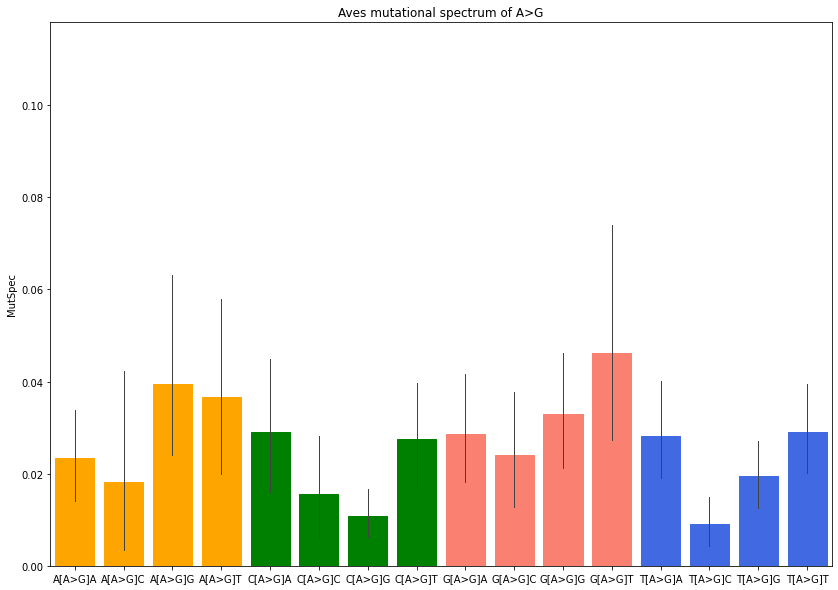

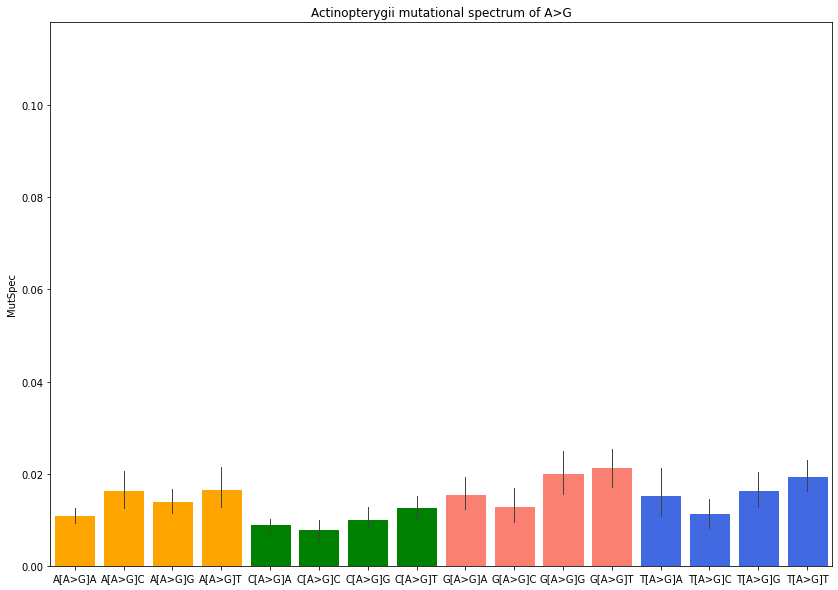

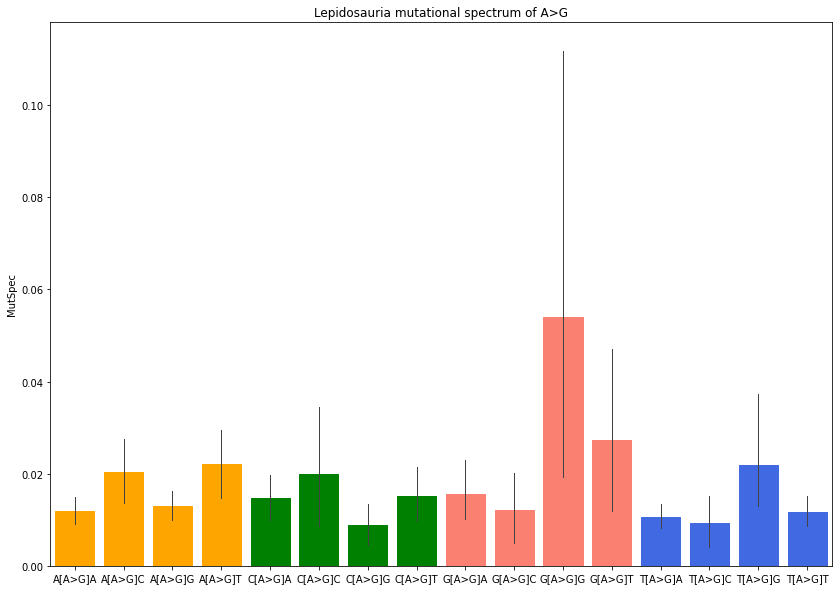

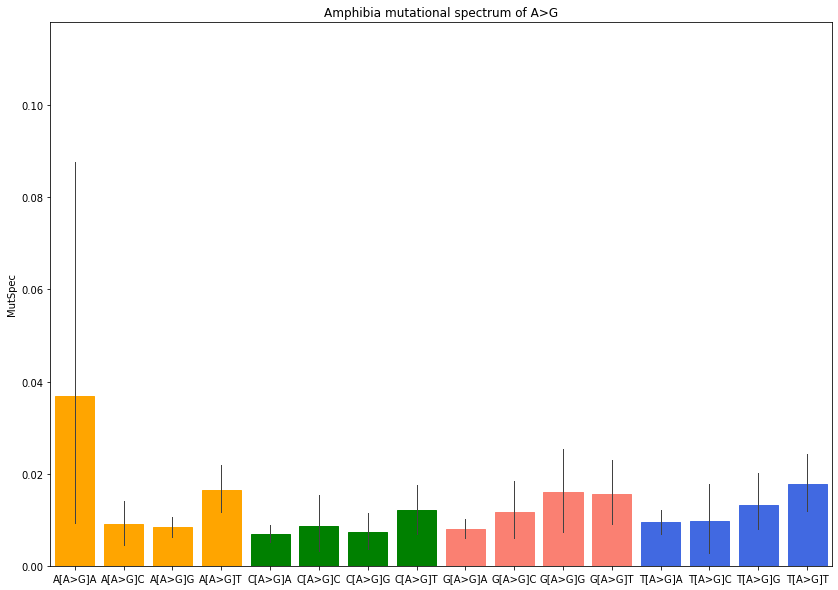

In [ ]:
for tx in taxes_to_draw:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111)   
    sns.barplot(x="Mut", y="MutSpec", data=AG_only[AG_only.Class == tx],
                order=A_G_arr, errwidth=1, ax=fig.gca())
    for bar, clr in zip(ax.patches, colorsAG):
        bar.set_color(clr)
    ax.set_xlabel('')
    ax.set_title(f'{tx} mutational spectrum of A>G')
    ax.set_ylim(0, 0.118)